# Introduction to LangGraph

In this tutorial, we will build a support chatbot in LangGraph that can:

- Answer common questions by searching the web
- Maintain conversation state across calls
- Route complex queries to a human for review
- Use custom state to control its behavior
- Rewind and explore alternative conversation paths

We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

## Setup

First, install the required packages:

In [1]:
# %%capture --no-stderr
# %pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
# %pip install -U langchain_anthropic

Next, set your API keys:

In [2]:
# import getpass
# import os


# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("ANTHROPIC_API_KEY")

(Encouraged) [LangSmith](https://smith.langchain.com/) makes it a lot easier to see what's going on "under the hood."

In [3]:
# _set_env("LANGSMITH_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [4]:
import os
import logging
from dotenv import load_dotenv

In [5]:
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

load_dotenv()

True

## Part 1: Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [6]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

**Notice** that we've defined our `State` as a TypedDict with a single key: `messages`. The `messages` key is annotated with the [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function, which tells LangGraph to append new messages to the existing list, rather than overwriting it.

So now our graph knows two things:

1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be _appended_ to the current list, rather than directly overwritten. This is communicated via the prebuilt [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function in the `Annotated` syntax.

Next, add a "`chatbot`" node. Nodes represent units of work. They are typically regular python functions.

In [7]:
# from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

# llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm = ChatOpenAI(
    temperature=0.0,
    model_name="gpt-4o"
)

In [8]:
llm.invoke("hi")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_729ea513f7', 'finish_reason': 'stop', 'logprobs': None}, id='run-753463a5-27d5-46de-b8d8-2a3c4c09e7a3-0')

In [9]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

**Notice** how the `chatbot` node function takes the current `State` as input and returns an updated `messages` list. This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

Next, add an `entry` point. This tells our graph **where to start its work** each time we run it.

In [10]:
graph_builder.set_entry_point("chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [11]:
graph_builder.set_finish_point("chatbot")

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "`CompiledGraph`" we can use invoke on our state.

In [12]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

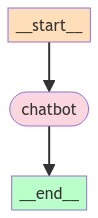

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

Now let's run the chatbot! 

**Tip:** You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [14]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Assistant: "Tam" could refer to a variety of people, characters, or things depending on the context. Here are a few possibilities:

1. **Tam O'Shanter**: A character from a famous poem by Robert Burns, a Scottish poet. The poem tells the story of Tam, who encounters witches and other supernatural beings on his way home from a tavern.

2. **Tam Lin**: A character from a Scottish folk ballad. Tam Lin is a young man captured by the Queen of the Fairies and later rescued by his true love, Janet.

3. **Tam (short for Tamara or Tammy)**: A common given name that could refer to any number of people.

4. **Tam (hat)**: A type of hat, often associated with Scottish culture, also known as a tam o'shanter.

5. **Tam (abbreviation)**: Could be an abbreviation for various organizations, terms, or names, such as TAM Airlines (a Brazilian airline), Total Addressable Market (a business term), or others.

If you have a specific context or additional information, I can provide a more precise answer.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Assistant: Hello! How can I assist you today?
Goodbye!


**Congratulations!** You've built your first chatbot using LangGraph. This bot can engage in basic conversation by taking user input and generating responses using an LLM. You can inspect a [LangSmith Trace](https://smith.langchain.com/public/29ab0177-1177-4d25-9341-17ae7d94e0e0/r) for the call above at the provided link.

However, you may have noticed that the bot's knowledge is limited to what's in its training data. In the next part, we'll add a web search tool to expand the bot's knowledge and make it more capable.

Below is the full code for this section for your reference:

In [15]:
from typing import Annotated

from langchain_openai import ChatOpenAI

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(
    temperature=0.0,
    model_name="gpt-4o"
)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

## Part 2: Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

#### Requirements

Before we start, make sure you have the necessary packages installed and API keys set up:

First, install the requirements to use the [Tavily Search Engine](https://python.langchain.com/docs/integrations/tools/tavily_search/), and set your [TAVILY_API_KEY](https://tavily.com/).

In [16]:
# %%capture --no-stderr
# %pip install -U tavily-python

In [17]:
# _set_env("TAVILY_API_KEY")

Next, define the tool:

In [18]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://python.langchain.com/v0.1/docs/langgraph/',
  'content': 'One of the central concepts of LangGraph is state. Each graph execution creates a state that is passed between nodes in the graph as they execute, and each node updates this internal state with its return value after it executes. The way that the graph updates its internal state is defined by either the type of graph chosen or a custom function.'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ...'}]

The results are page summaries our chat bot can use to answer questions.


Next, we'll start defining our graph. The following is all **the same as in Part 1**, except we have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [19]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOpenAI(
    temperature=0.0,
    model_name="gpt-4o"
)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls. It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it ourselves first is instructive.

In [20]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the `conditional_edges`. 

Recall that **edges** route the control flow from one node to the next. **Conditional edges** usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called `route_tools`, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next. 

The condition will route to `action` if tool calls are present and "`__end__`" if not.

Later, we will replace this with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) to be more concise, but implementing it ourselves first makes things more clear. 

In [21]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """Use in the conditional_edge to route to the ToolNode if the last message

    has tool calls. Otherwise, route to the end."""
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

**Notice** that conditional edges start from a single node. This tells the graph "any time the '`chatbot`' node runs, either go to 'action' if it calls a tool, or end the loop if it responds directly. 

The prebuilt `tools_condition` returns the "`__end__`" string if no tool calls are made. When the graph transitions to `__end__`, it has no more tasks to complete and ceases execution. Because the condition can return `__end__`, we don't need to explicitly set a `finish_point` this time. Our graph already has a way to finish!

Let's visualize the graph we've built. The following function has some additional dependencies to run that are unimportant for this tutorial.

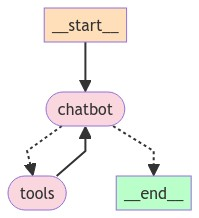

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

Now we can ask the bot questions outside its training data.

In [23]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Assistant: 
Assistant: [{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is framework agnostic (each node is a regular python function). It extends the core Runnable API (shared interface for streaming, async, and batch calls) to make it easy to: Seamless state management across multiple turns of conversation or tool usage. The ability to flexibly route between nodes based on dynamic criteria."}, {"url": "https://blog.langchain.dev/langgraph-multi-agent-workflows/", "content": "As a part of the launch, we highlighted two simple runtimes: one that is the equivalent of the AgentExecutor in langchain, and a second that was a version of that aimed at message passing and chat models.\n It's important to note that these three examples are only a few of the possible examples we could highlight - there are almost assuredly other examples out there and we look forward to seeing what the community comes up with!\n LangGraph: Multi-Agent Workflows\nLinks\nLast week we hi

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Assistant: LangGraph is a framework-agnostic tool designed to facilitate the creation and management of complex workflows involving multiple agents, particularly in the context of language models and AI. Here are some key features and aspects of LangGraph:

1. **Framework Agnostic**: Each node in LangGraph is a regular Python function, making it versatile and easy to integrate with various frameworks.
2. **Core Runnable API**: It extends the core Runnable API, which provides a shared interface for streaming, asynchronous, and batch calls.
3. **State Management**: LangGraph allows for seamless state management across multiple turns of conversation or tool usage.
4. **Dynamic Routing**: It offers the ability to flexibly route between nodes based on dynamic criteria.
5. **Multi-Agent Workflows**: LangGraph is designed to better enable the creation of LLM (Large Language Model) workflows containing cycles, which are critical for most agent runtimes.
6. **Integration with LangChain**: LangG

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Assistant: 
Assistant: [{"url": "https://www.datacamp.com/tutorial/introduction-to-langsmith", "content": "How it Works, Use Cases, Alternatives & More\nRichie Cotton\nHow AI is Changing Cybersecurity with Brian Murphy, CEO of ReliaQuest\nAdel Nehme\n32 min\nAn Introductory Guide to Fine-Tuning LLMs\nJosep Ferrer\n12 min\nSalesforce XGen-7B: A Step-by-Step Tutorial on Using And Fine-Tuning XGen-7B\nBex Tuychiev\n15 min\nGrow your data skills with DataCamp for Mobile\nMake progress on the go with our mobile courses and daily 5-minute coding challenges.\n For labeled datasets like the CSV dataset we uploaded, LangSmith offers more comprehensive evaluators for measuring the correctness of the response to a prompt:\nLet\u2019s try the last one on our examples:\nCoTQA criterion returns a score called Contextual accuracy, as depicted in the GIF below (also in the UI):\nPlease visit the LangChain evaluators section of LangSmith docs to learn much more about evaluators.\n Once the upload finis

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Assistant: LangSmith is a platform associated with LangChain, designed to help developers build and deploy large language model (LLM) applications with confidence. It offers a comprehensive suite of tools for every step of the application lifecycle, including:

1. **Prompt Management**: Allows teams to craft, debug, and capture feedback on prompts.
2. **Evaluation**: Provides built-in and custom evaluators for measuring the correctness of responses to prompts, especially useful for labeled datasets.
3. **Monitoring**: Helps in tracking application-level usage stats, feedback collection, performance comparison, and cost measurement.
4. **Collaboration**: Facilitates cross-team collaboration to refine, test, and version prompts in one place.

LangSmith aims to turn the development of LLM applications into enterprise-ready products by providing tools for dataset curation, AI-assisted evaluation, and easy benchmarking.
Goodbye!


**Congrats!** You've created a conversational agent in langgraph that can use a search engine to retrieve updated information when needed. Now it can handle a wider range of user queries. To inspect all the steps your agent just took, check out this [LangSmith trace](https://smith.langchain.com/public/24b94adc-3356-4d9f-8f94-813f8004fdbe/r).

Our chatbot still can't remember past interactions on its own, limiting its ability to have coherent, multi-turn conversations. In the next part, we'll add **memory** to address this.


The full code for the graph we've created in this section is reproduced below, replacing our `BasicToolNode` for the prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode), and our `route_tools` condition with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition)

In [24]:
from typing import Annotated, Union

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(
    temperature=0.0,
    model_name="gpt-4o"
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

## Part 3: Adding Memory to the Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off. 

We will see later that **checkpointing** is _much_ more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But before we get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.

To get started, create a `SqliteSaver` checkpointer.

In [25]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

**Notice** that we've specified `:memory` as the Sqlite DB path. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to connect to your own DB and/or use one of the other checkpointer classes.

Next define the graph. Now that you've already built your own `BasicToolNode`, we'll replace it with LangGraph's prebuilt `ToolNode` and `tools_condition`, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 2.

In [26]:
from typing import Annotated, Union

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(
    temperature=0.0,
    model_name="gpt-4o"
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

Finally, compile the graph with the provided checkpointer.

In [27]:
graph = graph_builder.compile(checkpointer=memory)

Notice the connectivity of the graph hasn't changed since Part 2. All we are doing is checkpointing the `State` as the graph works through each node.

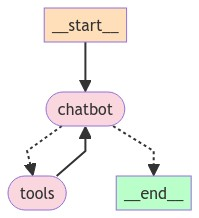

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [29]:
config = {"configurable": {"thread_id": "1"}}

Next, call your chat bot.

In [30]:
user_input = "Hi there! My name is Tam."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Tam.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Hello, Tam! How can I assist you today?


**Note:** The config was provided as the **second positional argument** when calling our graph. It importantly is _not_ nested within the graph inputs (`{'messages': []}`).

Let's ask a followup: see if it remembers your name.

In [31]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Got it, Tam! I'll remember your name. How can I help you today?


**Notice** that we are't the memory using an external list: it's all handled by the checkpointer! You can inspect the full execution in this [LangSmith trace](https://smith.langchain.com/public/48387889-c002-47a8-9f6a-1f6b298db64b/r) to see what's going on.

Don't believe me? Try this using a different config.

In [32]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

You haven't shared your name with me yet. Could you please tell me your name?


**Notice** that the **only** change we've made is to modify the `thread_id` in the config. See this call's [LangSmith trace](https://smith.langchain.com/public/4647adf6-3835-4ce3-ba39-26ed4f167411/r) for comparison. 

By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's `state` for a given config at any time, call `get_state(config)`.

In [33]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Tam.', id='650c98c3-68ca-45eb-b2c8-b2fa5fa6c895'), AIMessage(content='Hello, Tam! How can I assist you today?', response_metadata={'finish_reason': 'stop', 'logprobs': None, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_729ea513f7', 'token_usage': {'completion_tokens': 12, 'prompt_tokens': 87, 'total_tokens': 99}}, id='run-8eb1ddc8-28e4-4adc-b8c2-2b1f92658afd-0'), HumanMessage(content='Remember my name?', id='81205dfd-a879-4f6f-9fec-ba8ecd0535f5'), AIMessage(content="Got it, Tam! I'll remember your name. How can I help you today?", response_metadata={'finish_reason': 'stop', 'logprobs': None, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_729ea513f7', 'token_usage': {'completion_tokens': 18, 'prompt_tokens': 110, 'total_tokens': 128}}, id='run-d793c66c-f7ba-430b-9b44-6f69071c2045-0')]}, next=(), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef15bca-d7e3-641e-8004-7e150c07a825'}}, metadata={

In [34]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

The snapshot above contains the current state values, corresponding config, and the `next` node to process. In our case, the graph has reached an `__end__` state, so `next` is empty.

**Congratulations!** Your chatbot can now maintain conversation state across sessions thanks to LangGraph's checkpointing system. This opens up exciting possibilities for more natural, contextual interactions. LangGraph's checkpointing even handles **arbitrary complex graph states**, which is much more expressive and powerful than simple chat memory.

In the next part, we'll introduce human oversight to our bot to handle situations where it may need guidance or verification before proceeding.
  
Check out the code snippet below to review our graph from this section.

In [35]:
from typing import Annotated, Union

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(
    temperature=0.0,
    model_name="gpt-4o"
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

## Part 4: Human-in-the-loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph supports `human-in-the-loop` workflows in a number of ways. In this section, we will use LangGraph's `interrupt_before` functionality to always break the tool node.

First, start from our existing code. The following is copied from Part 3.

In [36]:
from typing import Annotated, Union

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = SqliteSaver.from_conn_string(":memory:")


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(
    temperature=0.0,
    model_name="gpt-4o"
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

Now, compile the graph, specifying to `interrupt_before` the `action` node.

In [37]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

In [38]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_1MM8hjqgHq1N349pObgi55o0)
 Call ID: call_1MM8hjqgHq1N349pObgi55o0
  Args:
    query: LangGraph programming language


Let's inspect the graph state to confirm it worked.

In [39]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

**Notice** that unlike last time, the "next" node is set to **'action'**. We've interrupted here! Let's check the tool invocation.

In [40]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph programming language'},
  'id': 'call_1MM8hjqgHq1N349pObgi55o0'}]

This query seems reasonable. Nothing to filter here. The simplest thing the human can do is just let the graph continue executing. Let's do that below.

Next, continue the graph! Passing in `None` will just let the graph continue where it left off, without adding anything new to the state.

In [41]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/tutorials/", "content": "These notebooks introduce LangGraph through building various language agents and applications. ... Competitive Programming\u00b6 Can Language Models Solve Olympiad Programming?: Build an agent with few-shot \"episodic memory\" and human-in-the-loop collaboration to solve problems from the USA Computing Olympiad; ..."}, {"url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "content": "4. Scalability: Langgraph is designed to handle large-scale language models with billions of parameters, enabling the development of state-of-the-art NLP applications. 5. Open-Source: Langgraph is an open-source project, allowing developers and researchers to collaborate, contribute, and build upon the framework. 6."}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

LangGraph is a framework designed for building language agents and applications. Here are some key points about it:

1. **Introduction and Tutorials**: LangGraph offers a series of tutorials that introduce the framework through various projects, such as building language agents and applications. These tutorials can be found on their [official website](https://langchain-ai.github.io/langgraph/tutorials/).

2. **Scalability**: LangGraph is designed to handle large-scale language models with billions of parameters. This makes it suitable for developing state-of-the-art Natural Language Processing (NLP) applications.

3. **Open-Source**: LangGraph is an open-source project, which means developers and researchers can collaborate, contribute, and build upon the framework.

For more detailed information, you can explore their [introduction tutorial](https://langchain-ai.github.io/langgraph/tutorials/introduction

Review this call's [LangSmith trace](https://smith.langchain.com/public/6a9012c0-bfa2-4fba-8dce-961d233f9512/r) to see the exact work that was done in the above call. Notice that the state is loaded in the first step so that your chatbot can continue where it left off.

**Congrats!** You've used an `interrupt` to add human-in-the-loop execution to your chatbot, allowing for human oversight and intervention when needed. This opens up the potential UIs you can create with your AI systems. Since we have already added a **checkpointer**, the graph can be paused **indefinitely** and resumed at any time as if nothing had happened.

Next, we'll explore how to further customize the bot's behavior using custom state updates.

Below is a copy of the code you used in this section. The only difference between this and the previous parts is the addition of the `interrupt_before` argument.

In [42]:
from typing import Annotated, Union

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessageGraph, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(
    temperature=0.0,
    model_name="gpt-4o"
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

## Part 5: Manually Updating the State

In the previous section, we showed how to interrupt a graph so that a human could inspect its actions. This lets the human `read` the state, but if they want to change they agent's course, they'll need to have `write` access.

Thankfully, LangGraph lets you **manually update state**! Updating the state lets you control the agent's trajectory by modifying its actions (even modifying the past!). This capability is particularly useful when you want to correct the agent's mistakes, explore alternative paths, or guide the agent towards a specific goal.

We'll show how to update a checkpointed state below. As before, first, define your graph. We'll reuse the exact same graph as before.

In [43]:
from typing import Annotated, Union

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessageGraph, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(
    temperature=0.0,
    model_name="gpt-4o"
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [44]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_sdXUj1xKnlGqv4vIy9QWX8SA)
 Call ID: call_sdXUj1xKnlGqv4vIy9QWX8SA
  Args:
    query: LangGraph programming language


So far, all of this is an _exact repeat_ of the previous section. The LLM just requested to use the search engine tool and our graph was interrupted. If we proceed as before, the tool will be called to search the web.

But what if the user wants to intercede? What if we think the chat bot doesn't need to use the tool? 

Let's directly provide the correct response!

In [45]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='0fd1e5af-be25-4f6c-a5af-0e029ea5d992', tool_call_id='call_sdXUj1xKnlGqv4vIy9QWX8SA'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='a6fa8ac3-9739-4f5a-b964-7a3b187b8ed7')]


Now the graph is complete, since we've provided the final response message! Since state updates simulate a graph step, they even generate corresponding traces. Inspec the [LangSmith trace](https://smith.langchain.com/public/c45207bb-bd26-4c9a-b631-928bbeebfbcb/r) of the `update_state` call above to see what's going on.

**Notice** that our new messages is _appended_ to the messages already in the state. Remember how we defined the `State` type?

```python
class State(TypedDict):
    messages: Annotated[list, add_messages]
```

We annotated `messages` with the pre-built `add_messages` function. This instructs the graph to always append values to the existing list, rather than overwriting the list directly. The same logic is applied here, so the messages we passed to `update_state` were appended in the same way!

The `update_state` function operates as if it were one of the nodes in your graph! By default, the update operation uses the node that was last executed, but you can manually specify it below. Let's add an update and tell the graph to treat it as if it came from the "chatbot".

In [46]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef15f4c-27ec-68e6-8003-bc1c0b401981'}}

Check out the [LangSmith trace](https://smith.langchain.com/public/ce83989f-6e49-4bdd-bcd5-f54ca55c8d00/r/30b1406a-ae5b-4e9e-9fe5-032be6efb92e) for this update call at the provided link. **Notice** from the trace that the graph continues into the `tools_condition` edge. We just told the graph to treat the update `as_node="chatbot"`. If we follow the diagram below and start from the `chatbot` node, we naturally end up in the `tools_condition` edge and then `__end__` since our updated message lacks tool calls.

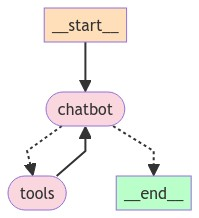

In [47]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

Inspect the current state as before to confirm the checkpoint reflects our manual updates.

In [48]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='0fd1e5af-be25-4f6c-a5af-0e029ea5d992', tool_call_id='call_sdXUj1xKnlGqv4vIy9QWX8SA'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='a6fa8ac3-9739-4f5a-b964-7a3b187b8ed7'), AIMessage(content="I'm an AI expert!", id='4631aaf2-95fa-4ffe-b958-4800366e70d7')]
()


**Notice**: that we've continued to add AI messages to the state. Since we are acting as the `chatbot` and responding with an AIMessage that doesn't contain `tool_calls`, the graph knows that it has entered a finished state (`next` is empty).

#### What if you want to **overwrite** existing messages? 

The [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function we used to annotate our graph's `State` above controls how updates are made to the `messages` key. This function looks at any message IDs in the new `messages` list. If the ID matches a message in the existing state, [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) overwrites the existing message with the new content. 

As an example, let's update the tool invocation to make sure we get good results from our search engine! First, start a new thread:

In [49]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_oPEV3fZZMS6zkwjfDWp3FRlY)
 Call ID: call_oPEV3fZZMS6zkwjfDWp3FRlY
  Args:
    query: LangGraph programming language


**Next,** let's update the tool invocation for our agent. Maybe we want to search for human-in-the-loop workflows in particular.

In [50]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-f5f816e2-6794-49cd-ab28-fda5296e255f-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph programming language'}, 'id': 'call_oPEV3fZZMS6zkwjfDWp3FRlY'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'call_oPEV3fZZMS6zkwjfDWp3FRlY'}
Message ID run-f5f816e2-6794-49cd-ab28-fda5296e255f-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'call_oPEV3fZZMS6zkwjfDWp3FRlY'}]

**Notice** that we've modified the AI's tool invocation to search for "LangGraph human-in-the-loop workflow" instead of the simple "LangGraph".

Check out the [LangSmith trace](https://smith.langchain.com/public/cd7c09a6-758d-41d4-8de1-64ab838b2338/r) to see the state update call - you can see our new message has successfully updated the previous AI message.

Resume the graph by streaming with an input of `None` and the existing config.

In [51]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraphjs/concepts/", "content": "Interruptions let you pause, get, and update the graph's state to enable human-in-the-loop workflows; Configurable parameters allow for runtime control separate from the regular data flow; For more examples and tutorials, check out the LangGraph.js documentation. If you have any questions or run into issues, don't hesitate to reach out on GitHub."}, {"url": "https://langchain-ai.github.io/langgraph/how-tos/human-in-the-loop/", "content": "Human-in-the-loop\u00b6 When creating LangGraph agents, it is often nice to add a human in the loop component. This can be helpful when giving them access to tools. ... from langgraph.graph import StateGraph, END # Define a new graph workflow = StateGraph (State) # Define the two nodes we will cycle between workflow. add_node (\"agent\", call_model) ..."}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

LangGraph is a tool that allows for the creation of human-in-the-loop workflows, which means it enables interruptions to pause, get, and update the graph's state. This feature is particularly useful for integrating human decision-making into automated processes. Here are some key points:

1. **Interruptions**: You can pause the workflow, retrieve the current state, and update it as needed. This is essential for human-in-the-loop scenarios where human intervention is required at certain stages.

2. **Configurable Parameters**: LangGraph allows for runtime control through configurable parameters, which are separate from the regular data flow. This provides flexibility in managing the workflow dynamically.

3. **Documentation and Support**: The LangGraph.js documentation offers examples and tutorials to help you get started. If you encounter any issues, you can reach out for support on GitHub.

For more deta

Check out the [trace](https://smith.langchain.com/public/2d633326-14ad-4248-a391-2757d01851c4/r/6464f2f2-edb4-4ef3-8f48-ee4e249f2ad0) to see the tool call and later LLM response. **Notice** that now the graph queries the search engine using our updated query term - we were able to manually override the LLM's search here!

All of this is reflected in the graph's checkpointed memory, meaning if we continue the conversation, it will recall all the _modified_ state.

In [52]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Yes, you're learning about LangGraph. If you have any specific questions or need further details on any aspect of LangGraph, feel free to ask!


**Congratulations!** You've used `interrupt_before` and `update_state` to manually modify the state as a part of a human-in-the-loop workflow. Interruptions and state modifications let you control how the agent behaves. Combined with persistent checkpointing, it means you can `pause` an action and `resume` at any point. Your user doesn't have to be available when the graph interrupts!

The graph code for this section is identical to previous ones. The key snippets to remember are to add `.compile(..., interrupt_before=[...])` (or `interrupt_after`) if you want to explicitly pause the graph whenever it reaches a node. Then you can use `update_state` to modify the checkpoint and control how the graph should proceed.

## Part 6: Customizing State

So far, we've relied on a simple state (it's just a list of messages!). You can go far with this simple state, but if you want to define complex behavior without relying on the message list, you can add additional fields to the state. In this section, we will extend our chat bot with a new node to illustrate this.

In the examples above, we involved a human deterministically: the graph __always__ interrupted whenever an tool was invoked. Suppose we wanted our chat bot to have the choice of relying on a human.

One way to do this is to create a passthrough "human" node, before which the graph will always stop. We will only execute this node if the LLM invokes a "human" tool. For our convenience, we will include an "ask_human" flag in our graph state that we will flip if the LLM calls this tool.

Below, define this new graph, with an updated `State`

In [6]:
from typing import Annotated, Union

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

Next, define a schema to show the model to let it decide to request assistance.

In [7]:
from langchain_core.pydantic_v1 import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

Next, define the chatbot node. The primary modification here is flip the `ask_human` flag if we see that the chat bot has invoked the `RequestAssistance` flag.

In [8]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(
    temperature=0.0,
    model_name="gpt-4o"
)
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

Next, create the graph builder and add the chatbot and tools nodes to the graph, same as before.

In [9]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

Next, create the "human" `node`. This `node` function is mostly a placeholder in our graph that will trigger an interrupt. If the human does __not__ manually update the state during the `interrupt`, it inserts a tool message so the LLM knows the user was requested but didn't respond. This node also unsets the `ask_human` flag so the graph knows not to revisit the node unless further requests are made.

In [10]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

Next, define the conditional logic. The `select_next_node` will route to the `human` node if the flag is set. Otherwise, it lets the prebuilt `tools_condition` function choose the next node.

Recall that the `tools_condition` function simply checks to see if the `chatbot` has responded with any `tool_calls` in its response message. If so, it routes to the `action` node. Otherwise, it ends the graph.

In [11]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

Finally, add the simple directed edges and compile the graph. These edges instruct the graph to **always** flow from node `a`->`b` whenever `a` finishes executing.

In [12]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

If you have the visualization dependencies installed, you can see the graph structure below:

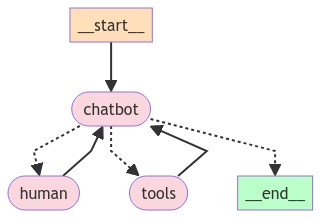

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

The chat bot can either request help from a human (chatbot->select->human), invoke the search engine tool (chatbot->select->action), or directly respond (chatbot->select->__end__). Once an action or request has been made, the graph will transition back to the `chatbot` node to continue operations.

Let's see this graph in action. We will request for expert assistance to illustrate our graph.

In [14]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (call_otvfOvjYeKZvcNi4Whx3eVFd)
 Call ID: call_otvfOvjYeKZvcNi4Whx3eVFd
  Args:
    request: I need expert guidance for building an AI agent.


**Notice:** the LLM has invoked the "`RequestAssistance`" tool we provided it, and the interrupt has been set. Let's inspect the graph state to confirm.

In [15]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

The graph state is indeed **interrupted** before the `'human'` node. We can act as the "expert" in this scenario and manually update the state by adding a new ToolMessage with our input.

Next, respond to the chatbot's request by:
1. Creating a `ToolMessage` with our response. This will be passed back to the `chatbot`.
2. Calling `update_state` to manually update the graph state.

In [16]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef16500-b0fe-6d82-8002-8835a18f64f5'}}

You can inspect the state to confirm our response was added.

In [17]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', id='cf0aa817-6aa8-4ae7-b1a4-e2f3863be20f'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"request":"I need expert guidance for building an AI agent."}', 'name': 'RequestAssistance'}, 'id': 'call_otvfOvjYeKZvcNi4Whx3eVFd', 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'logprobs': None, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_729ea513f7', 'token_usage': {'completion_tokens': 24, 'prompt_tokens': 160, 'total_tokens': 184}}, id='run-880d853e-2aca-4820-83a1-2cbbe7bd6b5c-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need expert guidance for building an AI agent.'}, 'id': 'call_otvfOvjYeKZvcNi4Whx3eVFd'}]),
 ToolMessage(content="We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autono

Next, **resume** the graph by invoking it with `None` as the inputs.

In [18]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

The experts recommend using LangGraph to build your AI agent, as it is more reliable and extensible than simple autonomous agents. If you have any specific questions or need further assistance, feel free to ask!


**Notice** that the chat bot has incorporated the updated state in its final response. Since **everything** was checkpointed, the "expert" human in the loop could perform the update at any time without impacting the graph's execution.

**Congratulations!** you've now added an additional node to your assistant graph to let the chat bot decide for itself whether or not it needs to interrupt execution. You did so by updating the graph `State` with a new `ask_human` field and modifying the interruption logic when compiling the graph. This lets you dynamically include a human in the loop while maintaining full **memory** every time you execute the graph.

We're almost done with the tutorial, but there is one more concept we'd like to review before finishing that connects `checkpointing` and `state updates`. 

This section's code is reproduced below for your reference.

In [19]:
from typing import Annotated, Union

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(
    temperature=0.0,
    model_name="gpt-4o"
)
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

## Part 7: Time Travel

In a typical chat bot workflow, the user interacts with the bot 1 or more times to accomplish a task. In the previous sections, we saw how to add memory and a human-in-the-loop to be able to checkpoint our graph state and manually override the state to control future responses.

But what if you want to let your user start from a previous response and "branch off" to explore a separate outcome? Or what if you want users to be able to "rewind" your assistant's work to fix some mistakes or try a different strategy (common in applications like autonomous software engineers)?

You can create both of these experiences and more using LangGraph's built-in "time travel" functionality. 

In this section, you will "rewind" your graph by fetching a checkpoint using the graph's `get_state_history` method. You can then resume execution at this previous point in time.

First, recall our chatbot graph. We don't need to make **any** changes from before:

In [27]:
from typing import Annotated, Union, Literal

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(
    temperature=0.0,
    model_name="gpt-4o"
)
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State) -> Literal["human", "tools", "__end__"]:
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

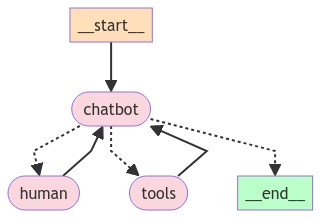

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

Let's have our graph take a couple steps. Every step will be checkpointed in its state history:

In [29]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_vq7JTliKSox3sslLetw27XHg)
 Call ID: call_vq7JTliKSox3sslLetw27XHg
  Args:
    query: LangGraph programming language
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/concepts/", "content": "Behind the seens, functions are converted to RunnableLambda's, which add batch and async support to your function, along with native tracing and debugging.. Edges\u00b6. Edges define how the logic is routed and how the graph decides to stop. Similar to nodes, they accept the current state of the graph and return a value.. By default, the value is the name of the node or nodes to send the state to ..."}, {"url": "https://langchain-ai.github.io/langgraph/tutorials/", "content": "These notebooks introduce LangGraph through building various language agents and app

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

LangGraph appears to be a framework or tool associated with LangChain, focusing on building language agents and applications. Here are some key points based on the search results:

1. **Concepts**:
   - Functions in LangGraph are converted to `RunnableLambda`s, which add batch and async support, along with native tracing and debugging.
   - Edges in LangGraph define how logic is routed and how the graph decides to stop. They accept the current state of the graph and return a value, typically the name of the node or nodes to send the state to.

2. **Tutorials**:
   - LangGraph offers tutorials that introduce the framework through building various language agents and applications.
   - One example is building an agent with few-shot "episodic memory" and human-in-the-loop collaboration to solve problems from the USA Computing Olympiad.

For more detailed information, you can explore the [LangGraph Concepts](

In [31]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it! Search for some examples.")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it! Search for some examples.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_fGgqdcbFROGJ5sECfnVoExEo)
 Call ID: call_fGgqdcbFROGJ5sECfnVoExEo
  Args:
    query: LangGraph autonomous agent examples
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://medium.com/@Shrishml/a-primer-on-ai-agents-with-langgraph-understand-all-about-it-0534345190dc", "content": "Hands-on Agents with LangGraph. ... In our example, a conditional edge is established from the tool execution node back to the router node. ... Task-driven Autonomous Agent Utilizing GPT-4 ..."}, {"url": "https://blog.langchain.dev/how-to-build-the-ultimate-ai-automation-with-multi-agent-collaboration/", "content": "This example will also leverage the leading autonomous research agent GPT Researcher. The Research Agent Team. The research team consists of seven LLM agents: Chief Editor \u2014 Oversees the

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Here are some examples and resources for building autonomous agents with LangGraph:

1. **Primer on AI Agents with LangGraph**:
   - This article provides a hands-on approach to building agents with LangGraph. It includes examples such as establishing a conditional edge from a tool execution node back to a router node.
   - It also discusses a task-driven autonomous agent utilizing GPT-4.
   - [Read more on Medium](https://medium.com/@Shrishml/a-primer-on-ai-agents-with-langgraph-understand-all-about-it-0534345190dc).

2. **Building the Ultimate AI Automation with Multi-Agent Collaboration**:
   - This blog post explains how to build an AI automation system with multi-agent collaboration using LangGraph.
   - It features an example leveraging the autonomous research agent GPT Researcher, which includes a team of seven LLM agents. The Chief Editor agent oversees the research process and manages the team, c

Now that we've had the agent take a couple steps, we can `replay` the full state history to see everything that occurred.

In [32]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-----------------------------------------

**Notice** that checkpoints are saved for every step of the graph. This _spans invocations__ so you can rewind across a full thread's history. We've picked out `to_replay` as a state to resume from. This is the state after the `chatbot` node in the second graph invocation above.

Resuming from this point should call the **action** node next.

In [33]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'thread_ts': '1ef16531-da1e-670e-8006-eb2fb5e72bd5'}}


**Notice** that the checkpoint's config (`to_replay.config`) contains a `thread_ts` **timestamp**. Providing this `thread_ts` value tells LangGraph's checkpointer to **load** the state from that moment in time. Let's try it below:

In [35]:
# The `thread_ts` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://medium.com/data-science-in-your-pocket/multi-agent-conversation-debates-using-langgraph-and-langchain-9f4bf711d8ab", "content": "Photo by Product School on Unsplash. In my last post on LangGraph, we already discussed a simple example where we can improve RAG by introducing cycles using LangGraph. Taking the game further ..."}, {"url": "https://blog.langchain.dev/langgraph-multi-agent-workflows/", "content": "As a part of the launch, we highlighted two simple runtimes: one that is the equivalent of the AgentExecutor in langchain, and a second that was a version of that aimed at message passing and chat models.\n It's important to note that these three examples are only a few of the possible examples we could highlight - there are almost assuredly other examples out there and we look forward to seeing what the community comes up with!\n LangGraph: Multi-Age

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Here are some examples and resources related to building autonomous agents using LangGraph:

1. **Multi-Agent Conversation Debates**:
   - An article on Medium discusses using LangGraph and LangChain to create multi-agent conversation debates. This example demonstrates how to improve Retrieval-Augmented Generation (RAG) by introducing cycles using LangGraph.
   - [Read more on Medium](https://medium.com/data-science-in-your-pocket/multi-agent-conversation-debates-using-langgraph-and-langchain-9f4bf711d8ab)

2. **Multi-Agent Workflows**:
   - A blog post on LangChain's official blog highlights the use of LangGraph for creating multi-agent workflows. It discusses two simple runtimes: one equivalent to the AgentExecutor in LangChain and another aimed at message passing and chat models.
   - The post emphasizes that these examples are just a few of the possible applications and encourages the community to exp

Notice that the graph resumed execution from the `**action**` node. You can tell this is the case since the first value printed above is the response from our search engine tool.

**Congratulations!** You've now used time-travel checkpoint traversal in LangGraph. Being able to rewind and explore alternative paths opens up a world of possibilities for debugging, experimentation, and interactive applications.

## Conclusion

Congrats! You've completed the intro tutorial and built a chat bot in LangGraph that supports tool calling, persistent memory, human-in-the-loop interactivity, and even time-travel!

The [LangGraph documentation](https://langchain-ai.github.io/langgraph/) is a great resource for diving deeper into the library's capabilities.